## Import necessary python modules

In [1]:
import os
import napari
import trackpy as tp
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tempfile import TemporaryFile
import bigfish
import bigfish.plot as plot
import bigfish.stack as stack
import bigfish.detection as detection
import bigfish.multistack as multistack

import liveQuant as lv

from tkinter import *
import tkinter as tk
from tkinter import filedialog
from random import sample 
pd.set_option('display.max_rows', 1500)
from copy import deepcopy
from dask.array.image import imread as imr
from bigfish.detection.utils import get_object_radius_pixel

from pathlib import Path
from napari.layers import Image
from magicgui import magicgui, magic_factory, widgets
from magicgui.widgets import Table
import bigfish.segmentation as segmentation
from skimage.segmentation import find_boundaries
from skimage.morphology.selem import disk
from napari.types import ImageData, LabelsData
from skimage.measure import label, regionprops

C:\Users\uid-1204\AppData\Local\anaconda3\envs\bigfishLive\lib\site-packages\bigfish\segmentation\nuc_segmentation.py:16: FutureWarning: The `skimage.morphology.selem` module is deprecated and will be removed in scikit-image 1.0 (`skimage.morphology.selem` has been moved to `skimage.morphology.footprints`).
  from skimage.morphology.selem import disk


## Specify voxel and object size


In [2]:
voxelRadius = (600, 121, 121)
objectRadius = (600, 150, 150)

In [3]:
# import napari
# viewer = napari.Viewer()

In [4]:
def find_txsite_in_blur_image(blurImage, voxelRadius2D, objectRadius2D,gAMMA, refSpot2D, bETA, clusterRadius, clusterSpotsMinimum, thresholdSelected, zETA):
    blurClusters = []
    thresholdManual = int(thresholdSelected)*zETA
    for t in range(len(blurImage)):

        rna = np.array(blurImage[t])

        # spot radius
        spot_radius_px = detection.get_object_radius_pixel(
            voxel_size_nm=voxelRadius2D,#(600, 80, 80), 
            object_radius_nm=objectRadius2D, 
            ndim=2)

        # LoG filter
        rna_log = stack.log_filter(rna, sigma=spot_radius_px)

        # local maximum detection
        mask = detection.local_maximum_detection(rna_log, min_distance=spot_radius_px)

        # thresholding
    #     threshold = detection.automated_threshold_setting(rna_log, mask)

        spots_current, _ = detection.spots_thresholding(rna_log, mask,thresholdManual)


        # gaussian kernel
        kernel_size = detection.get_object_radius_pixel(
            voxel_size_nm=voxelRadius2D, 
            object_radius_nm=objectRadius2D, 
            ndim=2)
        large_kernel_size = tuple([kernel_size_ * gAMMA for kernel_size_ in kernel_size])

        # denoising
        rna_denoised = stack.remove_background_gaussian(rna, sigma=large_kernel_size)


        # fit a gaussian function on the reference spot
        sigma_yx, amplitude, background = detection.modelize_spot(
            reference_spot=refSpot2D, 
            voxel_size=voxelRadius2D, 
            spot_radius=objectRadius2D)

        # detect dense regions
        regions_to_decompose, spots_out_regions, region_size = lv.get_dense_region_live(
            image=rna_denoised, 
            spots=spots_current,
            voxel_size=voxelRadius2D,
            spot_radius=objectRadius2D,
            reference_spot=refSpot2D,
            beta=bETA)

        print('time='+str(t))
        clusters = []
        ndim=2
        stack.check_array(
            rna,
            ndim=[2, 3],
            dtype=[np.uint8, np.uint16, np.float32, np.float64])
        # case where no region where detected
        if regions_to_decompose.size == 0:
            dense_regions = np.array([], dtype=rna.dtype).reshape((0, ndim + 4))
            blurClusters.append(np.array([],dtype=np.int64).reshape((0, 2)))
        #    return spots, dense_regions, reference_spot
        else :
            # precompute gaussian function values
            max_grid = max(200, region_size + 1)
            precomputed_gaussian = detection.precompute_erf(
                ndim=2,
                voxel_size=voxelRadius2D,
                sigma=(sigma_yx, sigma_yx),
                max_grid=max_grid)

            # simulate gaussian mixtures
            spots_in_regions, _ = detection.simulate_gaussian_mixture(
                image=rna,
                candidate_regions=regions_to_decompose,
                voxel_size=voxelRadius2D,
                sigma=(sigma_yx, sigma_yx),
                amplitude=amplitude,
                background=background,
                precomputed_gaussian=precomputed_gaussian)

            spots_post_decomposition = np.concatenate((spots_out_regions, spots_in_regions[:, :2]), axis=0)

            spots_post_clustering, clusters = detection.detect_clusters(
                spots=spots_post_decomposition, 
                voxel_size=voxelRadius2D, 
                radius=clusterRadius, 
                nb_min_spots=clusterSpotsMinimum)


            blurClusters.append(clusters[:,0:2])
    return blurClusters

from scipy.optimize import curve_fit

def bi_exp(x, a, b, c, d):
    return (a * np.exp(-b * x)) + (c * np.exp(-d * x))

def trip_exp(x, a, b, c, d, e, f):
    return ((a * np.exp(-b * x)) + (c * np.exp(-d * x)) + (e * np.exp(-f * x)))

def getBleachCorrected(stackCell, model='bi'):
    axes = tuple([i for i in range(len(stackCell.shape))])
    I_mean = np.mean(stackCell, axis=axes[1:])
    timePoints = np.arange(stackCell.shape[0])
    
    if model=='bi':
        coeffsExp, _ = curve_fit(bi_exp, timePoints, I_mean, maxfev=50000)
        f_ = np.vectorize(bi_exp)(timePoints, *coeffsExp)
    elif model=='tri':
        coeffsExp, _ = curve_fit(trip_exp, timePoints, I_mean, maxfev=50000)
        f_ = np.vectorize(trip_exp)(timePoints, *coeffsExp)
    
    
    f = f_ / np.max(f_)
    f = f.reshape(-1, 1, 1, 1)
    imagesCorrected = (stackCell / f).astype(np.uint16)

    # calculate r squared
    residuals = I_mean - f_
    ss_res = np.sum(residuals ** 2)
    ss_tot = np.sum((I_mean - np.mean(I_mean)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    r_squared_exp = np.array(r_squared)
    return imagesCorrected, r_squared_exp, I_mean

def getImagesAndSpotList(sequenceCell, selectedThreshold, voxelRadius, objectRadius, sampling=10):
    images=[]    
    spots_list=[]
    MaxTimePoint = sequenceCell.shape[0]

    spot_radius_px = detection.get_object_radius_pixel(
        voxel_size_nm=voxelRadius, 
        object_radius_nm=objectRadius, 
        ndim=3)

    for t in range(1,MaxTimePoint,sampling):
        rna = np.array(sequenceCell[t])
        images.append(rna)

        # LoG filter
        rna_log = stack.log_filter(rna, sigma=spot_radius_px)

        # local maximum detection
        mask = detection.local_maximum_detection(rna_log, min_distance=spot_radius_px)

        # thresholding
        threshold = detection.automated_threshold_setting(rna_log, mask)
        spots_, _ = detection.spots_thresholding(rna_log, mask, float(selectedThreshold))
        spots_list.append(spots_)
    n=len(images)
    print("Total number of images : "+str(n))
    return images, spots_list, n

def choose_home_folder():
    root = tk.Tk()
    root.withdraw()  # Hide the main window

    file_path = filedialog.askdirectory(initialdir= "/", title='Please select a directory')  # Open file dialog

    root.destroy()  # Close the tkinter window
    return file_path


def findFitstTxFrame(blurClusters):
    for i in range(len(blurClusters)):  
        if blurClusters[i].size!=0:
            return i

def findSpotBrightness2D(spotList, blurImage):
    meanBrightness = []
    for hh in range(len(spotList)):
#         z = spotList[hh,0]
        y = spotList[hh,0]
        x = spotList[hh,1]
        meanBrightness.append(np.sum(np.array(blurImage[y-3:y+4,x-3:x+4])))
    return meanBrightness

from runBigfishDetection import getSpotAndClusters
def mergeTxSites(clusterFrames):
    newCluster = np.zeros((1,5))
    newCluster[0,0:3]=clusterFrames[np.argmax(clusterFrames[:,3]), 0:3]
    newCluster[0,3]= np.sum(clusterFrames[:,3])
    return newCluster


def df2List(potentialTxs):
    newClusterFrame=[]
    
    for i in range(len(potentialTxs)):
        if potentialTxs.iloc[i,1:].sum()!=0:
            newClusterFrame.append(np.array(potentialTxs.iloc[i,1:]).reshape((1, 5)))
        else:
            newClusterFrame.append(np.array([], dtype=np.int64).reshape((0, 5)))
    return newClusterFrame
def findSpotBrightness(spotList, sequenceCell):
    meanBrightness = []
    for hh in range(len(spotList)):
        z = spotList[hh,0]
        y = spotList[hh,1]
        x = spotList[hh,2]
        meanBrightness.append(np.sum(np.array(sequenceCell[z-3:z+4,y-3:y+4,x-3:x+4])))
    return meanBrightness

def findMissingTxSite(selectedThreshold, sequenceCell, reference_spot,cellNumber, t,Tx_label_clean, lastLocation, bETA, gAMA=5, numCs=2, reorderTF = False):
    spots_T, clusters_T, _ = getSpotAndClusters(sequenceCell,
                                             reference_spot, 
                                             cellnumber=cellNumber, 
                                             startTime=t,
                                             stopTime=t+1, 
                                             thresholdManual=selectedThreshold, 
                                             beta=bETA, 
                                             gamma=gAMA,
                                             numberOfSpots=numCs,
                                             radiusCluster=400, 
                                             voxelSize=voxelRadius, 
                                             objectSize=objectRadius,
                                             reorder=reorderTF,
                                             extensionMov='.tif',
                                             showProgress=False)

    if len(clusters_T[0])>3*len(spots_T[0]):
        print(len(spots_T[0]))
        print(len(clusters_T[0]))
        print('beta very low! Increase the beta!')
        
    mask_in_frames = Tx_label_clean[clusters_T[0][:,1], clusters_T[0][:,2]]
    missingTx0 = clusters_T[0][mask_in_frames]
    if missingTx0.size!=0:
        idxs = np.where(np.sum(np.abs(missingTx0[:,0:3] - lastLocation), axis=1)<=10)[0]
        if idxs.size!=0:
            missingTx = mergeTxSites(missingTx0[idxs,:])
            return missingTx
        else:
            print('not found (not close to last location)')
            return missingTx0[idxs,:]
    else:
        print('not found (not in mask)')
        return missingTx0
        

def df2ClusterData(potentialTxs):
    newClusterFrame=[]
    
    for i in range(MaxTimePoint):
        if np.sum(potentialTxs.loc[potentialTxs['frame']==i][['z','y', 'x','mrna']]).sum()!=0:
            clustersFound = np.array(potentialTxs.loc[potentialTxs['frame']==i][['z','y', 'x','mrna', 'cluster_id']])
            lsize=sum(np.sum(clustersFound[:,:-1], axis=1).astype(bool))
            newClusterFrame.append(clustersFound[np.sum(clustersFound[:,:-1], axis=1).astype(bool)].reshape((lsize, 5)))
        else:
            newClusterFrame.append(np.array([], dtype=np.int64).reshape((0, 5)))
    return newClusterFrame

def makeTrackData(potentialTxsFinal):
    newClusterFrame = df2ClusterData(potentialTxsFinal)
    columnsid=['frame']
    for clidu in np.unique(potentialTxsFinal.cluster_id):
        if clidu ==0:
            Tx1 = potentialTxsFinal[potentialTxsFinal['cluster_id']==0]
            tableToDisplay = pd.DataFrame(Tx1.loc[:,['frame', 'mrna']].astype(int))
            columnsid.append('mrna_'+str(clidu))
        else:
            Tx2 = potentialTxsFinal[potentialTxsFinal['cluster_id']==clidu]
            tableToDisplay = pd.concat([tableToDisplay , Tx2.loc[:,['mrna']].astype(int)], axis=1)
            columnsid.append('mrna_'+str(clidu))
    tableToDisplay.columns = columnsid
    columnHd = tableToDisplay.columns[1:]
    dftracksFinal = pd.concat([potentialTxsFinal['cluster_id'],potentialTxsFinal['frame'],potentialTxsFinal.loc[:,['y','x']]], axis=1)
    dd=dftracksFinal.sort_values(by=['cluster_id', 'frame'])
    tracks_data = np.asarray(dd)
    dftracksFinal = dftracksFinal[np.sum(dftracksFinal.iloc[:,2:],axis=1)!=0]
    return columnHd, newClusterFrame, tableToDisplay, dftracksFinal

def makeFeatures(blurClusters):
    features = pd.DataFrame(blurClusters[0][:,0:],columns=['y','x'])
    features['frame']=1
    for ll in range(1,len(blurClusters)):
        new_row = pd.DataFrame(blurClusters[ll][:,0:],columns=['y','x'])
        new_row['frame']=ll+1
        features = pd.concat([features,new_row], ignore_index=True)
    return features
def makeNucboundaries(nuc_label):
    nuc_boundaries = None
    if nuc_label is not None:
        nuc_boundaries = find_boundaries(nuc_label, mode='thick')
        nuc_boundaries = stack.dilation_filter(
            image=nuc_boundaries,
            kernel_shape="disk",
            kernel_size=1)
        nuc_boundaries = np.ma.masked_where(
            nuc_boundaries == 0,
            nuc_boundaries)
        return nuc_boundaries
    
def makeTracks(linkedTrajectories):
    dft = pd.concat([linkedTrajectories.iloc[:,3:4], # particle
                        linkedTrajectories.iloc[:,2:3]-1, # frame
                        linkedTrajectories.iloc[:,0:2]], axis=1) # coord
    dft.columns = ['track_id','t','y','x']
    dd=dft.sort_values(by=['track_id', 't'])
    tracks_data = np.asarray(dd)
    return tracks_data


def runTrackpy(coord_in, disRange, memoryRange):
    linkedTrajectories = tp.link(coord_in, disRange, memory=memoryRange) #15 first
    linkedTrajectories['track_length']=0
    trajectoryLengths = linkedTrajectories['particle'].value_counts()
    i=0
    for jj in trajectoryLengths.index:
        linkedTrajectories.loc[linkedTrajectories['particle']==jj,'track_length']=trajectoryLengths.values[i]
        i+=1
    return linkedTrajectories


def getRegionSpotsandTracks(region, outfile, cell_label_clean, blurImage, dRange=6, mRange=100, shouldIPlot=False):
    nuc_label = cell_label_clean==region
    npzfile = np.load(outfile+'.npz', allow_pickle=True)
    blurClusters = npzfile['blurClusters']
    shouldIPlot = False

    numberOfTranscriptionSites = 1
    for i in range(len(blurClusters)):
        if blurClusters[i].size!=0:      
            mask_in_frames = nuc_label[blurClusters[i][:,0], blurClusters[i][:,1]]
            blurClusters[i] = blurClusters[i][mask_in_frames]

    if len(blurClusters[findFitstTxFrame(blurClusters)])>= 2:
        print('choose spot!')
        brightestSpot = blurClusters[findFitstTxFrame(blurClusters)][np.argmax(findSpotBrightness2D(blurClusters[findFitstTxFrame(blurClusters)], blurImage[findFitstTxFrame(blurClusters)]))]
        blurClusters[findFitstTxFrame(blurClusters)] = brightestSpot.reshape(1,2)

    lastLocation = blurClusters[findFitstTxFrame(blurClusters)]
    for i in range(len(blurClusters)):
        if len(blurClusters[i])>numberOfTranscriptionSites:
            off=0
            on=1
            if blurClusters[i-1].size==0:
                potentialId = np.argmin(np.sum(np.power((blurClusters[i] - lastLocation),2), axis=1))
            else:
                potentialId = np.argmin(np.sum(np.power((blurClusters[i] - blurClusters[i-1]),2), axis=1))
            blurClusters[i] = blurClusters[i][potentialId,:].reshape((1,2))
            if blurClusters[i].size==0 and off==0:
                off=1
                on=0
                print('switch off at', i)
            if off==1 and blurClusters[i].size!=0:
                on=1
                off=0
        elif len(blurClusters[i])==0:
            off=1
            on=0

        elif len(blurClusters[i])==1:
            off=0
            on=1
            lastLocation = deepcopy(blurClusters[i])

    features = makeFeatures(blurClusters)  
    nuc_boundaries = makeNucboundaries(nuc_label)
    if shouldIPlot==True:
        plt.scatter(features.iloc[:,1],features.iloc[:,0], s=1)
        plt.imshow(nuc_boundaries)

    mask_in = nuc_label[features.iloc[:, 0], features.iloc[:, 1]]
    coord_in = features[mask_in]
    coord_out = features[~mask_in]

    if coord_in.size==0:
        print('No clusters found!!')
    else: 
        print('Some clusters found! proceed! :)')
        if shouldIPlot==True:
            plt.scatter(coord_in.iloc[:,1],coord_in.iloc[:,0], s=1)
        linkedTrajectories = runTrackpy(coord_in, disRange=dRange, memoryRange=mRange)
        tracks_data = makeTracks(linkedTrajectories)
    return linkedTrajectories, tracks_data, blurClusters


## Select home folder

In [15]:
midentifier = 'cell_'
maxtime = 899

In [16]:
baseFolder = choose_home_folder() #homeFolder+nameKey+imsQ
thresholdFolder=('/').join(baseFolder.split('/')[:-1])
thresholdFile = pd.read_csv(baseFolder+'/thresholds.csv', index_col=0)

print("Chosen home folder:", baseFolder) # folder containg folder of movies
sessionNames = [os.path.join(baseFolder+'/'+i) for i in os.listdir(baseFolder) if midentifier in i and os.path.isdir(os.path.join(baseFolder,i)) and len(os.listdir(os.path.join(baseFolder,i)))>maxtime]

pathToResults= baseFolder+'/results/'
try:
    os.makedirs(pathToResults)
except FileExistsError:
   # directory already exists
   pass

Chosen home folder: C:/Users/uid-1204/Desktop/test2_bigFISHLIVE/Hela_h9_h2_k11_mcpsg_1hrbasal_14hr_TNF_TSA_exp2_2_F06


## Enter the alpha chosen in the last step

In [17]:
al = input('Enter the alpha chosen in the last step :')

Enter the alpha chosen in the last step :0.6


## Choose the movie

In [44]:
# Create the root window
root = Tk()
root.geometry('180x200')
 
# Create a listbox
listbox = Listbox(root, width=90, height=100, selectmode=SINGLE)
 
# Inserting the listbox items
for i in range(len(sessionNames)):
    listbox.insert(i+1, sessionNames[i].split('/')[-1])

# Function for printing the selected listbox value(s)
def selected_item():
    global chosenCell
    # Traverse the tuple returned by curselection method and print corresponding value(s) in the listbox
    chosenCell = listbox.get(listbox.curselection())
    root.destroy()
    
# Create a button widget and map the command parameter to selected_item function
btn = Button(root, text='Choose', command=selected_item)
 
# Placing the button and listbox
btn.pack(side='bottom')
listbox.pack()
 
root.mainloop()

## Specify Input and Output folders, identifiers

In [45]:
extension = '.tif'
namekey = sessionNames[0].split('/')[-2]
pathToSaveFrames = os.path.join(baseFolder,'blurs','blur_'+chosenCell+extension)


blurImage = imr(pathToSaveFrames)[0]

cellNumber = chosenCell
idx = np.where(thresholdFile['cell'] == cellNumber)[0][0]
MaxTimePoint = blurImage.shape[0]

thresholdSelected = thresholdFile['threshold'][idx]
sequenceCell = imr(os.path.join(baseFolder,str(cellNumber),'*.tif'))
mipSequenceCell = np.max(sequenceCell, axis=1)
spcl = np.load(os.path.join(baseFolder,str(cellNumber),str(cellNumber)+'_spots_and_clusters_27_May'+al+'.npz'),allow_pickle=True)
outfile = os.path.join(baseFolder,str(cellNumber),str(cellNumber)+'_blurClusters')#TemporaryFile() 

reference_spot = spcl['reference_spot']
refSpot = deepcopy(reference_spot)
potentialTxsFinal=[]
alphaRefSpot = 0.4
refSpot2D = np.max(reference_spot, axis=0)*alphaRefSpot
cellNumber

'cell_8'

array([1, 2], dtype=int64)

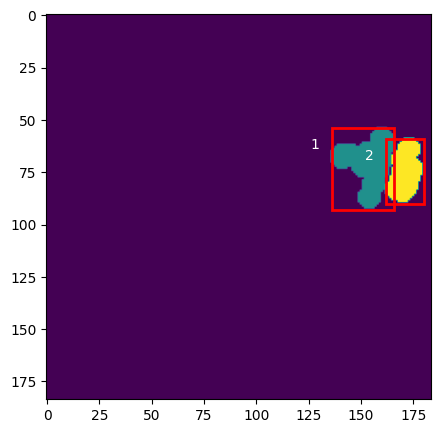

In [46]:
cell_label_clean = np.load(os.path.join(baseFolder,'masks_tx','blur_'+cellNumber+'.npy'))
nuc_label = np.array(label(cell_label_clean),dtype=bool)

import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(cell_label_clean)
for region in regionprops(cell_label_clean):
    # take regions with large enough areas
#     if region.area >= 2:
        # draw rectangle around segmented coins
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    ax.text(minc-10, minr+10, region.label, color='white', fontsize=10)
np.unique(cell_label_clean)[1:]

## Run detection on blurred image

In [47]:
VOXEL_RADIUS_2D = (0,0)
OBJECT_RADIUS_2D = (0,0)

DEFAULT_CHOICES=['None']

DEBUG = False

THRS = 100
BETA = 1
ZETA = 1
GAMMA = 3
NBSPOTS = 2
RADIUSCLUSTER_NM = 600

sampleNumber = 5
sampleFrames = sample(range(MaxTimePoint),sampleNumber)
stackCell = blurImage[sampleFrames]

@magicgui(main_window=False,
          call_button='Set voxel parameters',
          voxel_radius_xy = {"widget_type": "IntSlider", 'max': 1000},
          object_radius_xy = {"widget_type": "IntSlider", 'max': 1000})

def setVoxelandObjectParameters(voxel_radius_xy = 121,
                                object_radius_xy=150,
    ):

    voxelRadius = (voxel_radius_xy, voxel_radius_xy)
    objectRadius = (object_radius_xy, object_radius_xy)
    return voxelRadius, objectRadius

@setVoxelandObjectParameters.called.connect
def on_set_vb_parameters(value: list):
    global VOXEL_RADIUS_2D
    global OBJECT_RADIUS_2D
    VOXEL_RADIUS_2D = value[0]
    OBJECT_RADIUS_2D = value[1]
    if DEBUG==True: 
        print('voxel ', VOXEL_RADIUS_2D)
        print('object', OBJECT_RADIUS_2D)

@magicgui(main_window=False,
        call_button="Verify threshold",
        threshold = {"widget_type": "IntSlider", 'max': 6000},
        beta = {"widget_type": "FloatSlider", 'max': 5},
        zeta = {"widget_type": "FloatSlider", 'max': 5},
        gamma = {"widget_type": "IntSlider", 'max': 30},
        number_of_min_spots = {"widget_type": "IntSlider", 'max': 10},
        radius_of_cluster_nm = {"widget_type": "IntSlider", 'max': 1000},
        other_button=dict(widget_type="PushButton", text="Do for all frames"),
         )

def recordThreshold(img_layer: "napari.layers.Image", 
                    threshold=thresholdSelected, 
                    beta=0.7,
                    zeta=0.4,
                    gamma=5, 
                    number_of_min_spots=3,
                    radius_of_cluster_nm=400,
                    other_button=True,
                   ):
    image_data = img_layer.data
    stackCellSample = image_data

    return stackCellSample, threshold, beta, zeta, gamma, number_of_min_spots, radius_of_cluster_nm

@recordThreshold.called.connect
def on_verify_threshold(value: str):
    print('calling verify threshold')
    stackCellSample = value[0]
    global THRS, BETA, ZETA,GAMMA,NBSPOTS,RADIUSCLUSTER_NM 
    THRS = value[1]
    spots_current_list = []
    BETA = value[2]
    ZETA = value[3]
    GAMMA = value[4]
    NBSPOTS = value[5]
    RADIUSCLUSTER_NM  = value[6]
    refSpot2D = np.max(reference_spot, axis=0)*ZETA
    spotList = find_txsite_in_blur_image(stackCellSample, VOXEL_RADIUS_2D, OBJECT_RADIUS_2D,GAMMA, refSpot2D, BETA, RADIUSCLUSTER_NM, NBSPOTS, THRS, ZETA)

    spotList = formatSpotsShape(spotList)

    bigfish_Spots = viewer.add_points(
        spotList,
        face_color='#00000000',
        size=8,
        edge_width=0.3,
        edge_width_is_relative=False,
        edge_color='white',
        name = 'bigFish Detected Spots '+str(THRS)
        )
    
@recordThreshold.other_button.clicked.connect
def doForAllFrames(value: str):
    refSpot2D = np.max(reference_spot, axis=0)*ZETA
    blurClusters = find_txsite_in_blur_image(blurImage, VOXEL_RADIUS_2D, OBJECT_RADIUS_2D,GAMMA, refSpot2D, BETA, RADIUSCLUSTER_NM, NBSPOTS, THRS, ZETA)
    np.savez(outfile, blurClusters=blurClusters, allow_pickle=True)


@magicgui(main_window=False,
         call_button="Resample",
         )
def resampleMovie():
    sampleNumber = 5
    sampleFrames = sample(range(MaxTimePoint),sampleNumber)
    stackCell = blurImage[sampleFrames]
    viewer.layers.select_all()
    viewer.layers.remove_selected()
    image_layer = viewer.add_image(stackCell,
                             colormap='green',
                                name='stackCell')

    
@magicgui(main_window=False,
         call_button="View Frames",
         )
def viewSpecificFrames(frame_number = 1):
    sampleFrames = np.array([frame_number-1,frame_number,frame_number+1])
    stackCell = blurImage[sampleFrames]
    viewer.layers.select_all()
    viewer.layers.remove_selected()
    image_layer = viewer.add_image(stackCell,
                             colormap='green',
                                name='stackCell')
    
def formatSpotsShape(spotList):
    spotArray = np.hstack([np.ones((len(spotList[0]),1))*0, spotList[0]])
    for i in range(1,len(spotList)):
        spotArray = np.vstack([spotArray,np.hstack([np.ones((len(spotList[i]),1))*i, spotList[i]])])
    return spotArray 


container = widgets.Container(
    widgets=[setVoxelandObjectParameters,
             recordThreshold, 
             resampleMovie,viewSpecificFrames], layout="vertical", labels=False
)



container.native.setMinimumWidth(500)

viewer = napari.Viewer()

image_layer = viewer.add_image(
        stackCell, colormap='green' #maxImageCell
        )
viewer.window.add_dock_widget(container, area="right", name = 'threshold estimation')

calling verify threshold
calling verify threshold
time=0
time=1
time=2
time=3
time=4
calling verify threshold
time=0
time=1
time=2
time=3
time=4
calling verify threshold
time=0
time=1
time=2
time=3
time=4
calling verify threshold
time=0
time=1
time=2
time=3
time=4
calling verify threshold
time=0
time=1
time=2
time=3
time=4
calling verify threshold
time=0
time=1
time=2
time=3
time=4
time=0
time=1
time=2
time=3
time=4
time=5
time=6
time=7
time=8
time=9
time=10
time=11
time=12
time=13
time=14
time=15
time=16
time=17
time=18
time=19
time=20
time=21
time=22
time=23
time=24
time=25
time=26
time=27
time=28
time=29
time=30
time=31
time=32
time=33
time=34
time=35
time=36
time=37
time=38
time=39
time=40
time=41
time=42
time=43
time=44
time=45
time=46
time=47
time=48
time=49
time=50
time=51
time=52
time=53
time=54
time=55
time=56
time=57
time=58
time=59
time=60
time=61
time=62
time=63
time=64
time=65
time=66
time=67
time=68
time=69
time=70
time=71
time=72
time=73
time=74
time=75
time=76
time=77
t

time=881
time=882
time=883
time=884
time=885
time=886
time=887
time=888
time=889
time=890
time=891
time=892
time=893
time=894
time=895
time=896
time=897


C:\Users\uid-1204\AppData\Local\anaconda3\envs\bigfishLive\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


time=0
time=1
time=2
time=3
time=4
time=5
time=6
time=7
time=8
time=9
time=10
time=11
time=12
time=13
time=14
time=15
time=16
time=17
time=18
time=19
time=20
time=21
time=22
time=23
time=24
time=25
time=26
time=27
time=28
time=29
time=30
time=31
time=32
time=33
time=34
time=35
time=36
time=37
time=38
time=39
time=40
time=41
time=42
time=43
time=44
time=45
time=46
time=47
time=48
time=49
time=50
time=51
time=52
time=53
time=54
time=55
time=56
time=57
time=58
time=59
time=60
time=61
time=62
time=63
time=64
time=65
time=66
time=67
time=68
time=69
time=70
time=71
time=72
time=73
time=74
time=75
time=76
time=77
time=78
time=79
time=80
time=81
time=82
time=83
time=84
time=85
time=86
time=87
time=88
time=89
time=90
time=91
time=92
time=93
time=94
time=95
time=96
time=97
time=98
time=99
time=100
time=101
time=102
time=103
time=104
time=105
time=106
time=107
time=108
time=109
time=110
time=111
time=112
time=113
time=114
time=115
time=116
time=117
time=118
time=119
time=120
time=121
time=122
tim

C:\Users\uid-1204\AppData\Local\anaconda3\envs\bigfishLive\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


## Make Track

In [48]:
region=np.unique(cell_label_clean)[1]
print('chosen region : ', region)
LNKTRJ = deepcopy([])
HM = deepcopy(baseFolder)
CN = deepcopy(cellNumber)
RGN = deepcopy(region)
TRCKDATA = deepcopy([])
numberOfTranscriptionSites=1
BCS = deepcopy([])
SET_TABLE = 0

@magicgui(auto_call=True,
          call_button='View Tracks', main_window=False,
          verifyTrackNumbersBtn=dict(widget_type="PushButton", text="Verify # of Track"),
          loadMaskBtn=dict(widget_type="PushButton", text="Load Mask"),
          saveTrackBtn=dict(widget_type="PushButton", text="Save Track"),
          
         )
def viewTrack(verifyTrackNumbersBtn=True,
              loadMaskBtn=True,
              saveTrackBtn=True):
    global TRCKDATA, BCS, LNKTRJ, SET_TABLE
    def getDetectedClustersForFrameBlur(pts_coordinates, frameNumer):
        sd = np.shape(pts_coordinates[frameNumer][:])
        pts_coords = np.empty([sd[0],sd[1]])
        for ii in range(np.shape(pts_coordinates[frameNumer][:])[0]):
            pts_coords[ii,:] = pts_coordinates[frameNumer][ii][:]
        return pts_coords

    def set_pts_features(tracks_layers, cls_layer, cluster_coordinate, step):
        # step is a 4D coordinate with the current slider position for each dim
        frameNumber = step[0]  # grab the leading ("time") coordinate
        cls_layer.data = getDetectedClustersForFrameBlur(cluster_coordinate,frameNumber)
        bigfish_tracks.display_id = True
    if 'TS tracks' not in viewer.layers:
        text = {
            'size': 10,
            'color': 'red',
            }
        cluster_coordinate_blur = BCS
        bigfish_clusters_blur = viewer.add_points(
                getDetectedClustersForFrameBlur(cluster_coordinate_blur,int(np.shape(blurImage)[0]/2)),
                face_color='#00000000',
                size=8,
                edge_width=0.3,
                edge_width_is_relative=False,
                edge_color='red',
                face_color_cycle = ['red'],
                symbol='diamond',
                name = 'bigFish Clusters',
                text=text
                
                )


        bigfish_tracks = viewer.add_tracks(TRCKDATA, 
                                               name='TS tracks')
        if len(LNKTRJ)!=0:
            dfmin = pd.DataFrame(LNKTRJ.loc[:,['particle','frame']])
            dftable = dfmin.to_dict()
            table = Table(value=dftable)
            tablewidget = viewer.window.add_dock_widget(table, tabify=False, name = 'track table')
            SET_TABLE = 1

        viewer.dims.events.current_step.connect(
            lambda event: set_pts_features(bigfish_tracks, bigfish_clusters_blur, cluster_coordinate_blur, event.value)
            )
        
@viewTrack.saveTrackBtn.clicked.connect
def onSaveTrack():
    global HM, LNKTRJ, CN, RGN
    particlesFound = np.unique(LNKTRJ.particle.values)
    if len(particlesFound)!=numberOfTranscriptionSites:
        print('Check track!')
    elif len(particlesFound)==numberOfTranscriptionSites:
        saveTrackPath = os.path.join(HM,str(CN)+'/'+str(CN)+'mrnaTracks_'+str(RGN)+'.pkl')
        LNKTRJ.to_pickle(saveTrackPath)
        print('Track saved for cell number {} and region number {}!'.format(CN.split('_')[-1], RGN))
        print('\n Regions : ', np.unique(cell_label_clean)[1:])
    
@viewTrack.verifyTrackNumbersBtn.clicked.connect
def onVerifyTrackNumbers():
    global LNKTRJ
    linkedTrajectories = deepcopy(LNKTRJ)   
    dft = pd.concat([linkedTrajectories.iloc[:,3:4], # particle
                    linkedTrajectories.iloc[:,2:3]-1, # frame
                    linkedTrajectories.iloc[:,0:2]], axis=1) # coord
    dft.columns = ['track_id','t','y','x']
    dd=dft.sort_values(by=['track_id', 't'])
    tracks_data = np.asarray(dd)
    particlesFound = np.unique(linkedTrajectories.particle.values)
    if len(particlesFound)!=numberOfTranscriptionSites:
        print('Check track!')
    elif len(particlesFound)==numberOfTranscriptionSites:
        print('All good!')

@viewTrack.loadMaskBtn.clicked.connect
def onLoadMask():
    viewer.add_image(nuc_label)
    
@magicgui(call_button='Remove Tracks', main_window=False)
def onRemoveTracks(track_selection_for_removal="0,1,2,3"):
    global TRCK, LNKTRJ, TRCKDATA
    linkedTrajectories = deepcopy(LNKTRJ)
    track_selection_for_removal = track_selection_for_removal.split(',')
    print('Remove tracks :', track_selection_for_removal)
    for TRCK in track_selection_for_removal:
        linkedTrajectories = linkedTrajectories.loc[linkedTrajectories['particle']!=int(TRCK)]
    tracks_data = makeTracks(linkedTrajectories)
    TRCKDATA = deepcopy(tracks_data)
    if 'TS tracks' in viewer.layers:
        viewer.layers.remove('TS tracks')
        bigfish_tracks = viewer.add_tracks(TRCKDATA, name='TS tracks')
        bigfish_tracks.display_id = True
    LNKTRJ = deepcopy(linkedTrajectories)
    

@magicgui(call_button='Merge Tracks', main_window=False)
def onMergeTracks(track_selection_for_merge="0,1,2,3"):
    global TRCK, LNKTRJ, TRCKDATA
    linkedTrajectories = deepcopy(LNKTRJ)
    track_selection_for_merge = track_selection_for_merge.split(',')
    print('Merge tracks :', track_selection_for_merge)
    for TRCK in track_selection_for_merge:
        linkedTrajectories.loc[linkedTrajectories['particle']==int(TRCK),'particle']=0
    
    linkedTrajectories = linkedTrajectories[linkedTrajectories['particle']==0]
    tracks_data = makeTracks(linkedTrajectories)
    TRCKDATA = deepcopy(tracks_data)

    if 'TS tracks' in viewer.layers:
        viewer.layers.remove('TS tracks')
        bigfish_tracks = viewer.add_tracks(TRCKDATA, name='TS tracks')
        bigfish_tracks.display_id = True
    LNKTRJ = deepcopy(linkedTrajectories)

    
@magicgui(call_button='Analyse Region', main_window=False)
def onAnalyseNextRegion(region_selection_for_analysis=str(RGN)):
    global TRCK, LNKTRJ, RGN, TRCKDATA, BCS, SET_TABLE
    linkedTrajectories = deepcopy(LNKTRJ)
    RGN=int(region_selection_for_analysis)
    linkedTrajectories, tracks_data, blurClusters = getRegionSpotsandTracks(RGN, outfile, cell_label_clean, blurImage, dRange=6, mRange=100, shouldIPlot=False)
    print('Tracks found for new region, ', RGN)
    if 'TS tracks' in viewer.layers:
        viewer.layers.remove('TS tracks')
    if 'bigFish Clusters' in viewer.layers:
        viewer.layers.remove('bigFish Clusters')
    if SET_TABLE == 1:
#         viewer.window.remove_dock_widget(tablewidget)
        SET_TABLE = 0
    LNKTRJ = deepcopy(linkedTrajectories)
    TRCKDATA = deepcopy(tracks_data)
    BCS = deepcopy(blurClusters)
    

@magicgui(call_button='Remove Cluster From Track', main_window=False)
def onShowSelection():
    global LNKTRJ, TRCKDATA
#     indicestobe = list(viewer.layers['bigFish Clusters'].selected_data)
#     print(viewer.layers['bigFish Clusters'].data[indicestobe])
    print(viewer.dims.current_step[0])
    linkedTrajectories = deepcopy(LNKTRJ)
#     print(linkedTrajectories[linkedTrajectories['frame']==viewer.dims.current_step[0]+1])
    linkedTrajectories = linkedTrajectories.loc[linkedTrajectories['frame']!=viewer.dims.current_step[0]+1]
    tracks_data = makeTracks(linkedTrajectories)
    TRCKDATA = deepcopy(tracks_data)
    if 'TS tracks' in viewer.layers:
        viewer.layers.remove('TS tracks')
        bigfish_tracks = viewer.add_tracks(TRCKDATA, name='TS tracks')
        bigfish_tracks.display_id = True
    LNKTRJ = deepcopy(linkedTrajectories)

    
@magicgui(call_button='Show track numbers', main_window=False)
def onShowTrackNumbers():
    global LNKTRJ
    print(np.unique(LNKTRJ.particle))

viewer = napari.Viewer()
image_layer = viewer.add_image(
        blurImage, colormap='green')
container = [viewTrack,
             onMergeTracks,
            onRemoveTracks,
             onAnalyseNextRegion,
             onShowSelection,
             onShowTrackNumbers
            ]
viewer.window.add_dock_widget(container, area="right", name = 'Make tracks')

Frame 898: 1 trajectories present.
Tracks found for new region,  1
